In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os,sys
sys.path.append(os.getcwd())

Populating the interactive namespace from numpy and matplotlib


In [2]:
from muzero.model import MuModel

In [3]:
env = gym.make("CartPole-v0")
m = MuModel(env.observation_space.shape, env.action_space.n)
env.reset()
m.ft(m.ht(env.state))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


(array([ 0.00968296, -0.01586482], dtype=float32),
 array([0.00260319], dtype=float32))

In [4]:
from muzero.game import Game, ReplayBuffer
replay_buffer = ReplayBuffer(100, 128)

In [5]:
def to_one_hot(x,n):
  ret = np.zeros([n])
  ret[x] = 1.0
  return ret

# enumerate the whole action space
K = 5
import itertools
aopts = list(itertools.product([0,1], repeat=K))
aoptss = np.array([[to_one_hot(x, 2) for x in aa] for aa in aopts])
aoptss = aoptss.swapaxes(0,1)
aoptss = [aoptss[x] for x in range(K)]

# TODO: this is naive search, replace with MCTS
def search(m, o_0, debug=False):
  # concatenate the current state with every possible action
  o_0s = np.repeat(np.array(o_0)[None], len(aopts), axis=0)
  ret = m.mu.predict([o_0s]+aoptss)
  v_s = ret[-3]
  
  # group the value with the action rollout that caused it
  v = [(v_s[i][0], aopts[i]) for i in range(len(v_s))]
  if debug:
    print(sorted(v, reverse=True))
  
  av = [0,0]
  for vk, ak in v:
    av[ak[0]] += vk
    
  policy = np.exp(av)/sum(np.exp(av))
  return policy

In [6]:
def play_game():
  import random
  game = Game(env)
  env.reset()
  while not game.terminal():
    act = np.random.choice([0,1], p=search(m, env.state))
    game.apply(act)
  return game

In [7]:
from muzero.model import reformat_batch
for j in range(50):
  game = play_game()
  replay_buffer.save_game(game)
  for i in range(10):
    m.train_on_batch(replay_buffer.sample_batch(5))
  print(len(game.history), m.losses[-1][0])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
15 335.47778
11 209.35901
15 168.80154
10 150.43478
10 123.98081
89 267.5024
14 189.80391
25 210.63751
16 152.61766
10 175.94736
13 188.17014
9 132.08826
10 101.0262
11 106.30493
14 140.6076
10 135.57143
21 109.742035
12 130.79973
12 109.0109
9 108.41203
10 125.23804
13 120.380295
14 103.078926
15 102.34717
19 110.33625
16 119.733025
13 99.344475
13 91.913475
9 98.54271
18 87.91856
13 98.2835
133 98.660385
24 74.05045
40 51.469078
67 75.15862
63 87.81295
54 51.435726
111 78.900536
112 95.64107
200 76.765495
200 99.147
112 87.08805
92 81.26444
200 89.88693
94 102.912415
200 100.32068
105 83.801704
200 90.55931
137 83.16762
200 101.72211


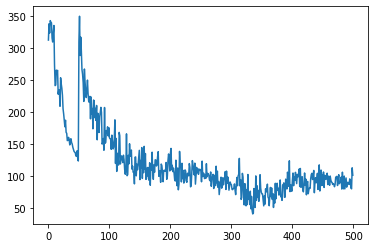

In [11]:
plot([x[0] for x in m.losses])

In [13]:
# can act?
env.reset()
for sn in range(200):
  p_0 = search(m, env.state, debug=False)
  v_0 = m.ft(m.ht(env.state))
  a_1 = np.random.choice([0,1], p=p_0)
  #a_1 = np.argmax(p_0)
  #print(p_0, v_0, a_1)
  env.render()
  _,r,done,_ = env.step(a_1)
  if done:
    print("DONE", sn)
    break

DONE 199
